## Installations

## Imports

In [53]:
from dotenv import find_dotenv, load_dotenv
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from warnings import filterwarnings
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns  
from datetime import datetime, timezone
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
filterwarnings("ignore")



In [52]:
load_dotenv(find_dotenv())

PROJECT_PATH=os.getenv('PROJECT_PATH')
MAX_T=int(os.getenv('MAX_T'))



## Methods

In [63]:
def read_file(file):
    df=pd.read_csv(file)

    return df


def get_all_players(df):
    all_whites=list(set(sorted(df["White"])))
    all_whites=sorted(all_whites)
    all_black=list(set(sorted(df["Black"])))
    all_black=sorted(all_black)
    all_players=list(set(all_whites+all_black))
    return all_players
def get_events_for_player(df,player):
    return Counter(list(df[(df["White"]==player)|(df["Black"]==player)]["Event"]))
def get_games_for_player(df,player):
    return df[(df["White"]==player)|(df["Black"]==player)]

def get_years_for_player(df,player):
    return dict(Counter(list(df[(df["White"]==player)|(df["Black"]==player)]["Year"])))
def get_years_for_player_game(df,player,game):
    return dict(Counter(list(df[((df["White"]==player)|(df["Black"]==player))&(df["Event"]==game)]["Year"])))
def get_players(df):
    w=list(df["White"])
    b=list(df["Black"])
    all=list(set((w+b)))
    return all

def get_games_for_player(df,player):
    player_black_df=df[df["Black"]==player]
    player_black_df=player_black_df[["UTCDate","BlackElo","UTCTime"]]
    player_black_df.rename(columns={'BlackElo':'Elo'},inplace=True)

    player_white_df=df[df["White"]==player]
    player_white_df=player_white_df[["UTCDate","WhiteElo","UTCTime"]]
    player_white_df.rename(columns={'WhiteElo':'Elo'},inplace=True)

    return pd.concat([player_black_df,player_white_df]).sort_values(by='UTCDate')


def date_to_num(date_str):
    # Parse the date string to datetime object
    date_obj = datetime.strptime(date_str, "%Y.%m.%d %H:%M:%S")

    # Convert the datetime object to Unix timestamp (seconds since epoch)
    unix_timestamp = date_obj.replace(tzinfo=timezone.utc).timestamp()
    return unix_timestamp

def get_players_atleast_x_games_type(x,game_type,df):

    df_c=(df[df["Event"]==" Blitz "])
    w=dict(df_c["White"].value_counts())
    b=dict(df_c["Black"].value_counts())
    all={}
    all=w
    for k,v in b.items():
        all[k]=all.get(k,0)+v
    h=[]
    for k,v in w.items():
        if v>200:
            h.append(k)
    len(h)

    #
    df=df[(df["White"].isin(h))|(df["Black"].isin(h))]

    #
    df1=df[(df["White"].isin(h))&(df["Black"].isin(h))]
    df1=df1[["White","WhiteElo","UTCDate","UTCTime"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    df2=df[(df["White"].isin(h))&(~df["Black"].isin(h))]
    df2=df2[["White","WhiteElo","UTCDate","UTCTime"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    #
    df3=df[(~df["White"].isin(h))&(df["Black"].isin(h))]
    df3=df3[["Black","BlackElo","UTCDate","UTCTime"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df4=df[(df["White"].isin(h))&(df["Black"].isin(h))]
    df4=df4[["Black","BlackElo","UTCDate","UTCTime"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df=pd.concat([df1,df2,df3,df4])
    return df

def classify(df,test_size,model,name):
    train, test = train_test_split(df, test_size=test_size)
    y_train, y_test = train['label'], test['label']
    X_train, X_test = train.drop('label', axis=1), test.drop('label', axis=1)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print("-"*100)
    print("Model name:",name)
    print("accuracy_score:",accuracy_score(y_test,y_predict))
    print("roc_auc_score:",roc_auc_score(y_test,y_predict))
    print("precision_score:",precision_score(y_test,y_predict))
    print("f1_score:",f1_score(y_test,y_predict))
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    print("-"*100)
    try:
        explainer = shap.Explainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)
    except Exception as err:
        pass
    return {
        'model':model,
        'accuracy':accuracy_score(y_test,y_predict),
        'precision':precision_score(y_test,y_predict),
        'recall':recall_score(y_test,y_predict),
        'f1':f1_score(y_test,y_predict),
        'name':name
           }
    
def compare_model_results(results):

    a, p, r, f,names = [], [], [], [],[]
    for res in results:
        a.append(res["accuracy"])
        p.append(res["precision"])
        r.append(res["recall"])
        f.append(res["f1"])
        names.append(res["name"])

    #
    model_score = pd.DataFrame([a,p,r,f],
                 columns = names).T.sort_values(by=3, ascending=False).rename(columns={0:'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1',}).round(4) 
    # Create a heatmap of the summary
    plt.figure(figsize= (10,10))
    sns.heatmap(model_score, annot=True, cmap = 'coolwarm')
    plt.show()
    

## Baseline classification(just use points no features)

In [55]:
with open(f"{PROJECT_PATH}/models/fics/player_series_labels_150_euclidean.pkl", 'rb') as f:
    player_series_labels=pickle.load(f)
players=set(player_series_labels.keys())

In [56]:
data_dict={
    "label":[]
}
for p in player_series_labels:
    num_games=len(player_series_labels[p]['games'])
    data_dict["label"].append(int(player_series_labels[p]["label"][0]==1))
    for i in range(0,min(num_games,MAX_T)):
        data_dict["t="+str(i)+""]=data_dict.get("t="+str(i),[])
        data_dict["t="+str(i)+""].append(player_series_labels[p]['games'][i])

df=pd.DataFrame.from_dict(data_dict)

In [57]:
df

,label,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,...,t=40,t=41,t=42,t=43,t=44,t=45,t=46,t=47,t=48,t=49
0,0,1783,1776,1785,1779,1790,1795,1792,1791,1789,...,1776,1785,1793,1781,1782,1768,1760,1756,1742,1725
1,1,1513,1500,1514,1504,1492,1491,1485,1478,1491,...,1554,1562,1557,1550,1558,1568,1567,1579,1571,1582
2,0,2220,2225,2229,2233,2237,2241,2245,2241,2245,...,2230,2227,2217,2207,2206,2212,2200,2206,2211,2216
3,1,1488,1512,1528,1541,1551,1518,1523,1500,1528,...,1538,1558,1563,1583,1598,1604,1615,1560,1575,1592
4,0,1551,1558,1565,1572,1578,1584,1589,1594,1583,...,1613,1607,1601,1595,1589,1584,1595,1589,1584,1579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5928,1,1356,1363,1371,1363,1357,1365,1371,1362,1362,...,1347,1337,1336,1345,1354,1361,1354,1345,1353,1362
5929,1,1577,1582,1569,1557,1545,1542,1551,1559,1561,...,1622,1613,1620,1628,1624,1623,1628,1639,1644,1647
5930,0,1181,1175,1174,1172,1165,1160,1147,1145,1162,...,1072,1073,1056,1041,1028,1016,1020,1009,999,990
5931,1,1666,1657,1649,1641,1636,1630,1622,1616,1626,...,1616,1626,1621,1616,1609,1603,1597,1607,1617,1625


In [58]:
models=[]

#### logistic regression

----------------------------------------------------------------------------------------------------
Model name: logistic regression
accuracy_score: 0.6756529064869419
roc_auc_score: 0.5794053662073966
precision_score: 0.5327102803738317
f1_score: 0.37194127243066877
----------------------------------------------------------------------------------------------------


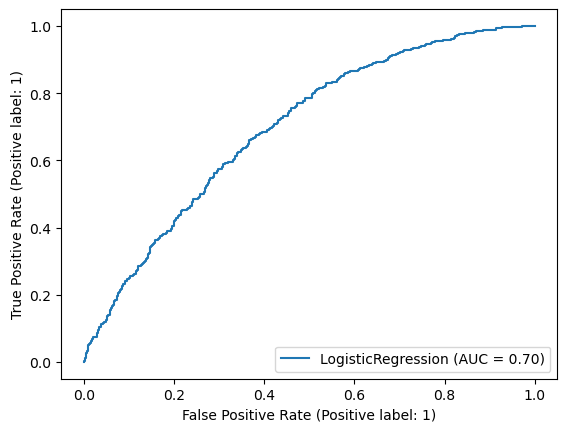

In [64]:
from sklearn.linear_model import LogisticRegression
models.append(classify(df,0.2,LogisticRegression(),"logistic regression"))

#### Support vector machines

----------------------------------------------------------------------------------------------------
Model name: Support vector machine
accuracy_score: 0.6478517270429655
roc_auc_score: 0.5290221498571472
precision_score: 0.5833333333333334
f1_score: 0.16733067729083664
----------------------------------------------------------------------------------------------------


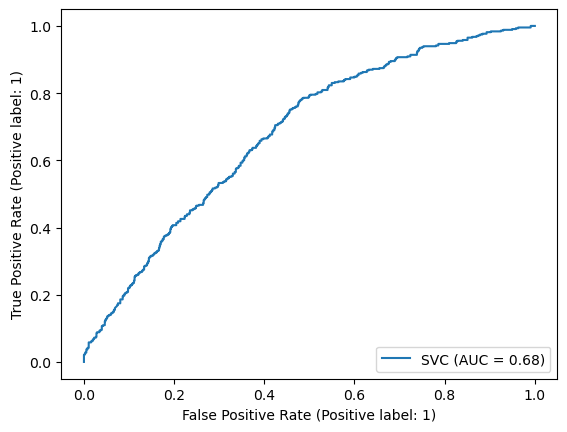

In [65]:
from sklearn.svm import SVC
models.append(classify(df,0.2,SVC(probability =True),"Support vector machine"))

#### Random Forrest

----------------------------------------------------------------------------------------------------
Model name: basic random forrest
accuracy_score: 0.624262847514743
roc_auc_score: 0.5607444491742395
precision_score: 0.4673202614379085
f1_score: 0.39071038251366125
----------------------------------------------------------------------------------------------------


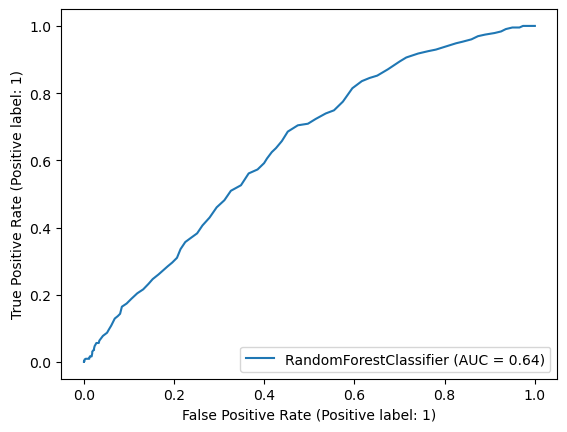

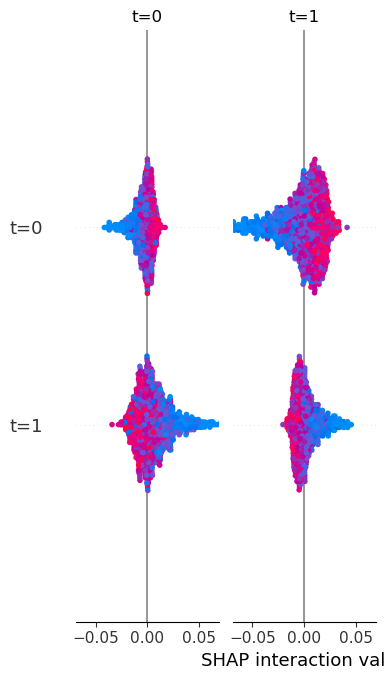

In [66]:
from sklearn.ensemble import RandomForestClassifier 
models.append(classify(df,0.2,RandomForestClassifier(n_estimators=100, random_state=42),"basic random forrest"))

#### Decision Tree

----------------------------------------------------------------------------------------------------
Model name: decision tree
accuracy_score: 0.6057287278854254
roc_auc_score: 0.5601808101808101
precision_score: 0.42355889724310775
f1_score: 0.41935483870967744
----------------------------------------------------------------------------------------------------


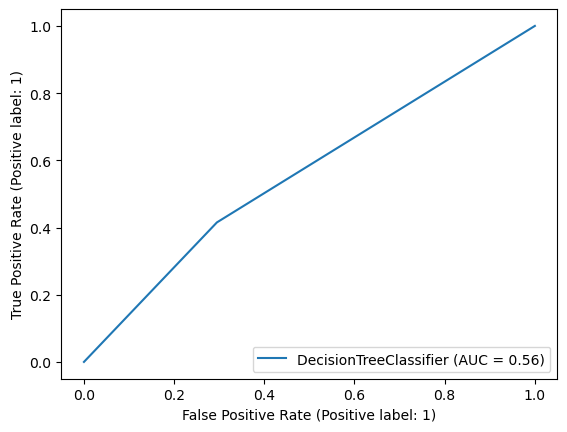

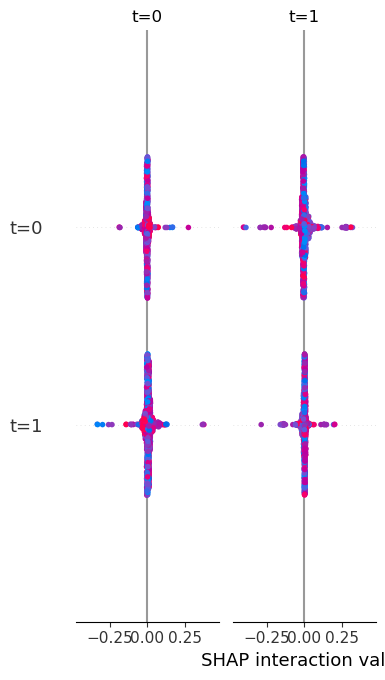

In [67]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
models.append(classify(df,0.2,DecisionTreeClassifier(random_state=42),"decision tree"))

#### Gaussian Naive Bayes

----------------------------------------------------------------------------------------------------
Model name: Gaussian Naive Bayes
accuracy_score: 0.5720303285593934
roc_auc_score: 0.5383514543258062
precision_score: 0.40271493212669685
f1_score: 0.41203703703703703
----------------------------------------------------------------------------------------------------


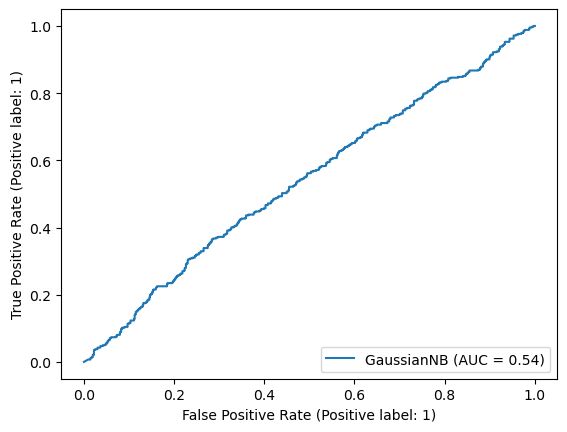

In [68]:
from sklearn.naive_bayes import GaussianNB  # For Gaussian Naive Bayes
models.append(classify(df,0.2,GaussianNB(),"Gaussian Naive Bayes"))

#### KNN

----------------------------------------------------------------------------------------------------
Model name: KNeighborsClassifier
accuracy_score: 0.6503791069924179
roc_auc_score: 0.5452442843720638
precision_score: 0.4911242603550296
f1_score: 0.2857142857142857
----------------------------------------------------------------------------------------------------


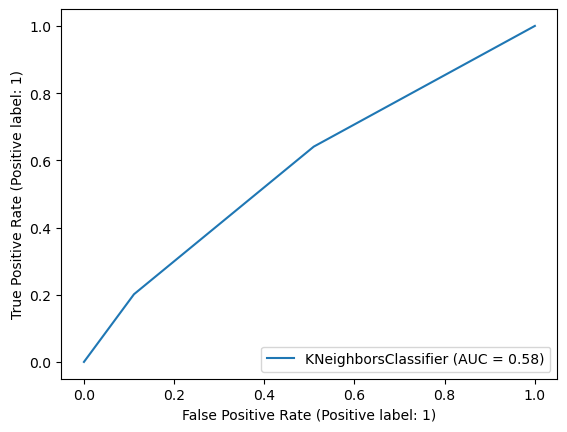

In [69]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier  
models.append(classify(df,0.2,KNeighborsClassifier(2),"KNeighborsClassifier"))

#### AdaBoostClassifier

----------------------------------------------------------------------------------------------------
Model name: AdaBoostClassifier
accuracy_score: 0.6798652064026959
roc_auc_score: 0.5653847368254871
precision_score: 0.5886524822695035
f1_score: 0.304029304029304
----------------------------------------------------------------------------------------------------


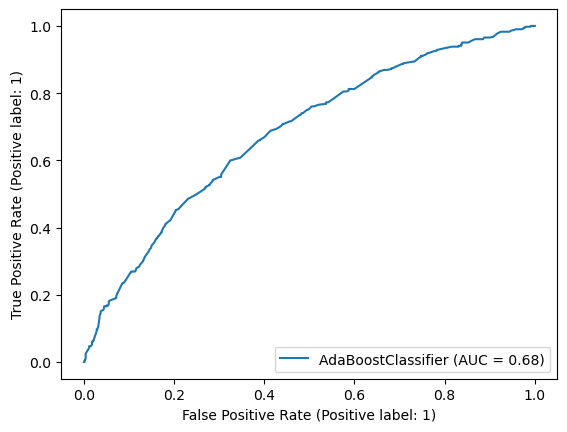

In [70]:
models.append(classify(df,0.2,AdaBoostClassifier(),"AdaBoostClassifier"))

#### CatBoostClassifier

Learning rate set to 0.020032
0:	learn: 0.6907157	total: 2.75ms	remaining: 2.75s
1:	learn: 0.6881816	total: 4.37ms	remaining: 2.18s
2:	learn: 0.6858398	total: 5.93ms	remaining: 1.97s
3:	learn: 0.6832321	total: 7.55ms	remaining: 1.88s
4:	learn: 0.6808593	total: 9.21ms	remaining: 1.83s
5:	learn: 0.6786386	total: 10.9ms	remaining: 1.81s
6:	learn: 0.6764113	total: 13.1ms	remaining: 1.86s
7:	learn: 0.6745717	total: 15.1ms	remaining: 1.87s
8:	learn: 0.6726264	total: 16.9ms	remaining: 1.86s
9:	learn: 0.6707113	total: 18.9ms	remaining: 1.87s
10:	learn: 0.6689597	total: 20.9ms	remaining: 1.88s
11:	learn: 0.6673056	total: 23.1ms	remaining: 1.9s
12:	learn: 0.6655363	total: 25.1ms	remaining: 1.9s
13:	learn: 0.6640350	total: 26.9ms	remaining: 1.9s
14:	learn: 0.6623064	total: 28.8ms	remaining: 1.89s
15:	learn: 0.6609336	total: 30.8ms	remaining: 1.89s
16:	learn: 0.6597139	total: 32.6ms	remaining: 1.88s
17:	learn: 0.6585278	total: 34.4ms	remaining: 1.88s
18:	learn: 0.6570699	total: 36.2ms	remaining: 1

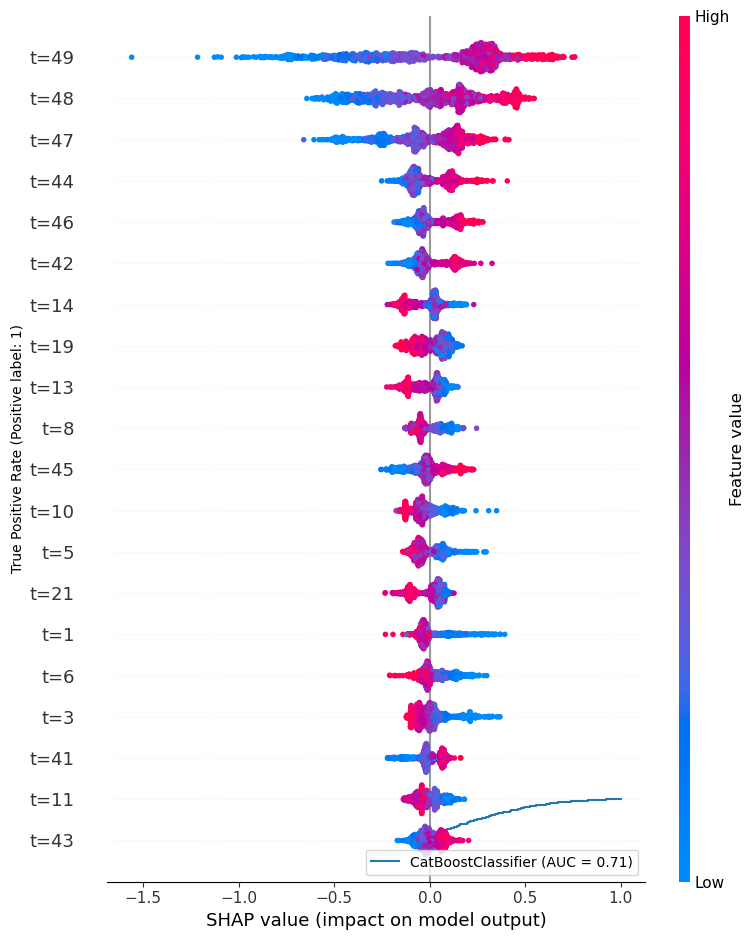

In [71]:
models.append(classify(df,0.2,CatBoostClassifier(),"CatBoostClassifier"))

#### XGBOOST

----------------------------------------------------------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.6503791069924179
roc_auc_score: 0.5942920340388929
precision_score: 0.5233644859813084
f1_score: 0.4474034620505991
----------------------------------------------------------------------------------------------------


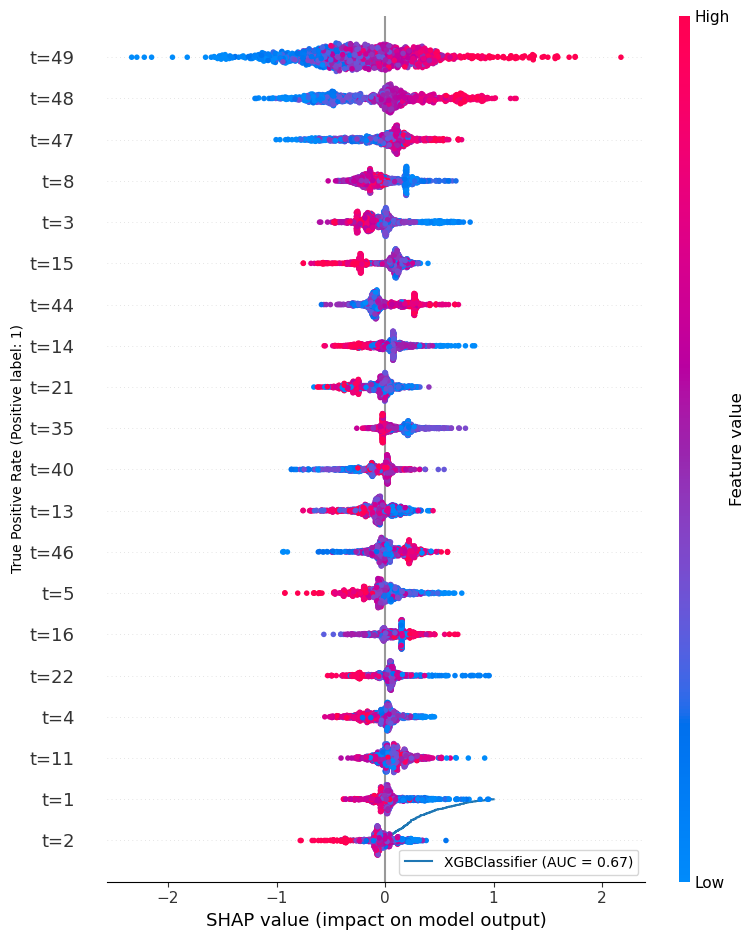

In [72]:
models.append(classify(df,0.2,XGBClassifier(),"XGBClassifier"))

#### LGBM

[LightGBM] [Info] Number of positive: 1655, number of negative: 3091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 4746, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348715 -> initscore=-0.624694
[LightGBM] [Info] Start training from score -0.624694
----------------------------------------------------------------------------------------------------
Model name: LGBMClassifier
accuracy_score: 0.649536647009267
roc_auc_score: 0.577056277056277
precision_score: 0.5018050541516246
f1_score: 0.4005763688760807
----------------------------------------------------------------------------------------------------


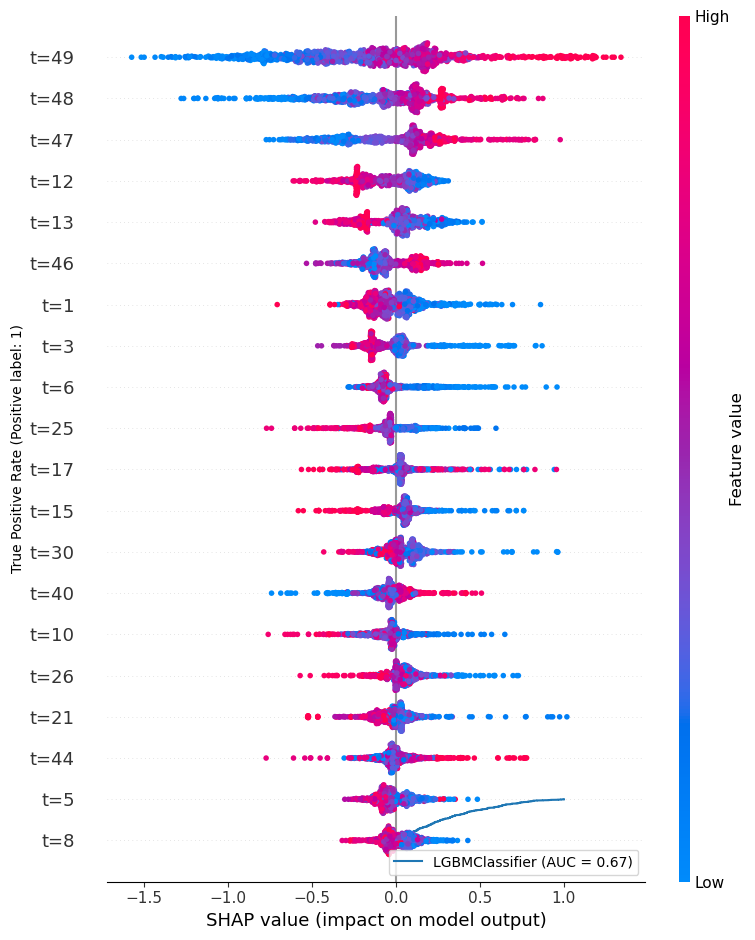

In [73]:
models.append(classify(df,0.2,LGBMClassifier(),"LGBMClassifier"))

#### Comparision

In [74]:
%matplotlib inline
def compare_model_results(results):

    a, p, r, f,names = [], [], [], [],[]
    for res in results:
        a.append(res["accuracy"])
        p.append(res["precision"])
        r.append(res["recall"])
        f.append(res["f1"])
        names.append(res["name"])
    #
    model_score = pd.DataFrame([a,p,r,f],
                 columns = names).T.sort_values(by=3, ascending=False).rename(columns={0:'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1',}).round(4) 
    print(model_score)


compare_model_results(models)

                        Accuracy  Precision  Recall      F1
decision tree             0.6201     0.4474  0.4950  0.4700
XGBClassifier             0.6504     0.5234  0.3907  0.4474
decision tree             0.6057     0.4236  0.4152  0.4194
Gaussian Naive Bayes      0.5720     0.4027  0.4218  0.4120
basic random forrest      0.6689     0.5551  0.3238  0.4090
LGBMClassifier            0.6495     0.5018  0.3333  0.4006
CatBoostClassifier        0.6799     0.5849  0.2981  0.3949
basic random forrest      0.6243     0.4673  0.3357  0.3907
logistic regression       0.6757     0.5327  0.2857  0.3719
AdaBoostClassifier        0.6799     0.5887  0.2049  0.3040
KNeighborsClassifier      0.6504     0.4911  0.2015  0.2857
Support vector machine    0.6479     0.5833  0.0977  0.1673
